<a href="https://colab.research.google.com/github/alexferrero23/twitter-category-nlp/blob/develop/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Best model search

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import glob
import re
import io

## Import your file

In order to start working, we have to import the file obtained from the notebook 'EDA.ipynb' in the same repository.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving working_df (1).orc to working_df (1).orc


In [3]:
import pyarrow.orc 

df_original = pd.read_orc('working_df (1).orc')

In [4]:
df_original.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length
0,RepAdams,2022-04-30 14:42:28,Today my thoughts are with the entire UNC Char...,en,D,3.0,17.0,263
1,RepAdams,2022-04-29 16:40:17,Welcome to the next President of DavidsonColle...,en,D,1.0,0.0,62
2,RepAdams,2022-04-29 01:52:24,"This WorkersMemorialDay, we remember countless...",en,D,2.0,3.0,262
3,RepAdams,2022-04-25 15:38:45,It’s a perfect date to celebrate the 40th Anni...,en,D,3.0,29.0,163
4,RepAdams,2022-04-22 19:57:41,Happy National Volunteer Week! Volunteers mak...,en,D,2.0,6.0,182


We are going to use a subset of the dataframe for two reasons: First, models take too much time to fit (unless you are using a huge and expensive machine, which is not my case) and secondly, it seems that more data doesn't lead to better results. At the end of this notebook there will be a more accurate explanation of this.



In [5]:
from sklearn.utils import shuffle
df_d = shuffle(df_original[df_original['label']=='D'])[:10000]
df_r = shuffle(df_original[df_original['label']=='R'])[:10000]
df = df_d.append(df_r, ignore_index=True)

## Model preprocesing

Before we start trying out models, we need to make some transformation in the data.
First, let's create a column with a list of words from tweets.
Library nltk contains three methods really usefull for this step:

 - stopwords returns a dictionary with useless words for our model.
 - TweetTokenizer allows us to convert the stream of words into small  tokens
 - SnowballStemmer is a stemming algorithm in charge of reducing the word to its word stem that affixes to suffixes and prefixes or to roots of words known as a lemma

In [6]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=list(stopwords.words('english'))
import string
stop.extend(('&amp;', '-', '…', '’', '“', '—', '”', 'amp'))
snow_stemmer = SnowballStemmer(language='english')

def create_corpus_column(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
    cleaned_corpus = []
    corpus = tokenizer.tokenize(tweet)
    for word in corpus:
        if (word not in stop) and (word not in string.punctuation):
             cleaned_corpus.append(snow_stemmer.stem(word))
    return cleaned_corpus

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
df['text_corpus'] = df['text'].apply(create_corpus_column)

In [8]:
df.head(5)

,username,created_at,text,lang,label,retweet_count,favorite_count,length,text_corpus
0,SaraJacobsCA,2018-06-05 17:44:31,This is what our campaign is all about!,en,D,1.0,17.0,40,[campaign]
1,RepKatiePorter,2019-06-17 15:13:31,"At a hearing in April, I asked jpmorgan CEO Ja...",en,D,890.0,3468.0,247,"[hear, april, ask, jpmorgan, ceo, jami, dimon,..."
2,RepHorsford,2021-08-04 00:20:02,"The ChildTaxCredit is a huge, well-deserved ta...",en,D,91.0,149.0,148,"[childtaxcredit, huge, well-deserv, tax, break..."
3,RepJahanaHayes,2021-07-13 23:20:19,Thank you for joining me for the ChildTaxCredi...,en,D,4.0,5.0,240,"[thank, join, childtaxcredit, inform, session,..."
4,RepKarenBass,2019-04-27 22:04:56,The attack against the Jewish community in Pow...,en,D,86.0,229.0,232,"[attack, jewish, communiti, poway, today, obse..."


### Cosine similarity

A very good exercise we can do now is check correlation between the two groups. As we are analyzing tweets from the same topic, it's evident that this correlation is going to be really big. Firstly, we unnest the column text_corpus.




In [9]:
df_tidy = df.explode(column='text_corpus')
df_tidy = df_tidy.drop(columns='text')
df_tidy.head(3)

,username,created_at,lang,label,retweet_count,favorite_count,length,text_corpus
0,SaraJacobsCA,2018-06-05 17:44:31,en,D,1.0,17.0,40,campaign
1,RepKatiePorter,2019-06-17 15:13:31,en,D,890.0,3468.0,247,hear
1,RepKatiePorter,2019-06-17 15:13:31,en,D,890.0,3468.0,247,april


In [10]:
# Data pivot by label
df_pivot = df_tidy.groupby(["label","text_corpus"])["text_corpus"] \
                .agg(["count"]).reset_index() \
                .pivot(index = "text_corpus" , columns="label", values= "count")
df_pivot.columns.name = None
df_pivot.head(3)

,D,R
text_corpus,,
(202) 224-2541,1.0,NaN
(202) 225-7084,1.0,NaN
(202)225-2211,NaN,1.0


Most used similarity measure when working with text is 1 - cosine distance.


In [11]:
from scipy.spatial.distance import cosine

def consine_similarity(a,b):
    distancia = cosine(a,b)
    return 1-distancia

df_pivot.corr(method=consine_similarity)

,D,R
D,1.00000,0.92739
R,0.92739,1.00000


Results are as we expected. This is actually really bad news, if there is a big correlation between both groups, its gonna be really difficult to say whether a tweet tends to be republican or democrat


### Feature extraction

For the feature extraction, I'm gonna use Tf-idf (Term frequency – Inverse document frequency). The goal is weighing words by how frequent they are in our dataset, discounting words that are too frequent, as they just add to the noise.
- Term Frequency: This summarizes how often a given word appears within a document.
- Inverse Document Frequency: This downscales words that appear a lot across documents.

For model purposes, lets change label from letters to numbers: R -> 0 and D -> 1:


In [12]:
df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

Let's do a train-test split making sure that the proportion in both sets is equivalent.

In [103]:
from sklearn.model_selection import train_test_split

datos_X = df.text
datos_y = df.label_number

X_train, X_test, y_train, y_test = train_test_split(
    datos_X,
    datos_y,
    test_size = 0.2,
    random_state = 123
    
)

In [104]:
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 49.90625, 1: 50.09375}
{0: 50.375, 1: 49.625}


Now, we are going to create the matrix of TF-IDF features:

In [110]:
#Tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer  = TfidfVectorizer(
                        tokenizer  = create_corpus_column,
                        min_df     = 5 #might change
                    )
vectorizer.fit(X_train)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


TfidfVectorizer(min_df=5,
                tokenizer=<function create_corpus_column at 0x7ff0afa1b290>)

In [111]:
d = vectorizer.vocabulary_
{k: d[k] for k in list(d)[:2]}

{'blow': 674, 'nativ': 2957}

In [112]:
tfidf_train = vectorizer.transform(X_train)
tfidf_test  = vectorizer.transform(X_test)

In [18]:
print(f"Number of tokens created: {len(vectorizer.get_feature_names_out())}");

Number of tokens created: 6723


The next function is used to visualize the embeddings in 2 dimensions. ALthough we are losing a lot of information with a dimensionality reduction, it's very useful to see the separation between groups.





In [19]:
from sklearn.decomposition import TruncatedSVD
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=2, alpha=.8, c=test_labels, cmap=ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='Republicans')
            green_patch = mpatches.Patch(color='blue', label='Democrats')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 20})

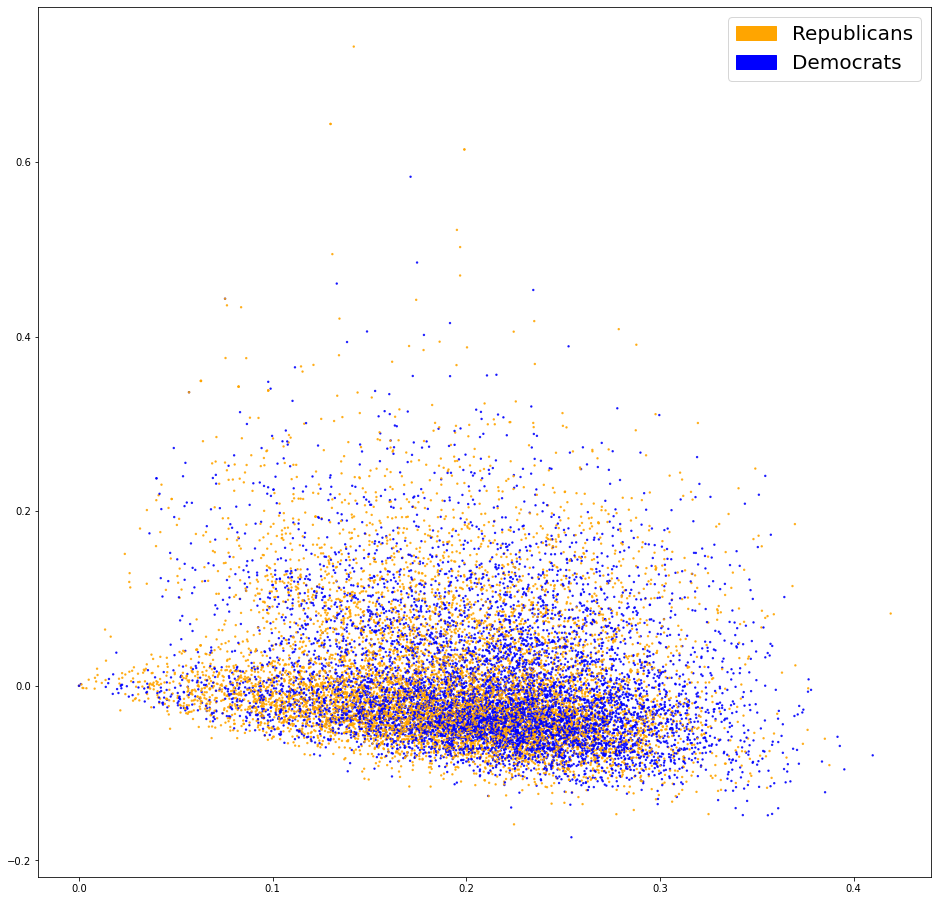

In [20]:
fig = plt.figure(figsize=(16, 16))          
plot_LSA(tfidf_train, y_train)
plt.show()

As we could expect, they are not very separated.




## Model selection

### Logistic regression

First model to be tested is the logistic regression.
Let's execute one first logistic regression with some 'random' hyperparameters and then do a grid search.

Hyperparameters used for this first try are:
 - C=30
 - solver='newton-cg' (good for multiclass problems, although this is a binary classification it can work well)
 - multi_class='multinomial'
 - n_jobs=-1 (use all processors)


In [21]:
%%time

from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=30.0, solver='newton-cg', 
                         multi_class='multinomial', n_jobs=-1)
log_reg.fit(tfidf_train, y_train)

y_hat = log_reg.predict(tfidf_test)

CPU times: user 57.6 ms, sys: 96.4 ms, total: 154 ms
Wall time: 2.83 s


Function to compute accuracy, precision, recall and f1 metrics

In [22]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics(y_test, y_hat): 
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_hat)

    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_hat, pos_label=None,
                                    average='weighted')             
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_hat, pos_label=None,
                              average='weighted')
    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_hat, pos_label=None, average='weighted')
    

    print(f'accuracy = {accuracy}, precision = {precision}, recall = {recall}, f1 = {f1}')

#### Logistic regression metrics

In [23]:
get_metrics(y_test, y_hat)

accuracy = 0.724, precision = 0.7240074188210067, recall = 0.724, f1 = 0.7239776399248763


In order to believe the value of the accuracy, per definition, it has to be bigger than the proportion of 1 in label_number in the dataset

In [24]:
prop_1s = len(df[df['label_number']==1])/len(df)
print(f'Proportion of 1\'s in label_number in the dataset: {prop_1s}')

Proportion of 1's in label_number in the dataset: 0.5


Function to calculate and plot the confusion matrix

In [25]:
from sklearn.metrics import confusion_matrix

def create_confusion_matrix(y_test, y_hat):
  
  conf_matrix = confusion_matrix(y_test, y_hat)
  plt.figure(figsize = (7,5))
  sns.heatmap(conf_matrix, annot=True, fmt='g');


#### Logistic regression's confusion matrix

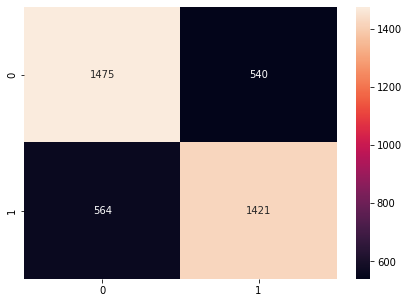

In [26]:
create_confusion_matrix(y_test, y_hat)

Function to calculate the ROC Curve and area under the ROC Curve

In [27]:
from sklearn.metrics import roc_auc_score, roc_curve

def create_roc_curve(model, y_test, y_train):

  fig = plt.figure(figsize=(10, 10))          

  fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(tfidf_test)[:, 1])
  plt.plot(fpr, tpr, label="Test");

  fpr, tpr, thresholds = roc_curve(y_train, model.predict_proba(tfidf_train)[:, 1])
  plt.plot(fpr, tpr, label="Train");

  plt.legend(loc="lower right", prop={'size': 20});

  print(f'ROC AUC SCORE: {roc_auc_score(y_test, model.predict_proba(tfidf_test)[:, 1])}')


#### Logistic regression's Roc curve

ROC AUC SCORE: 0.7989854429311649


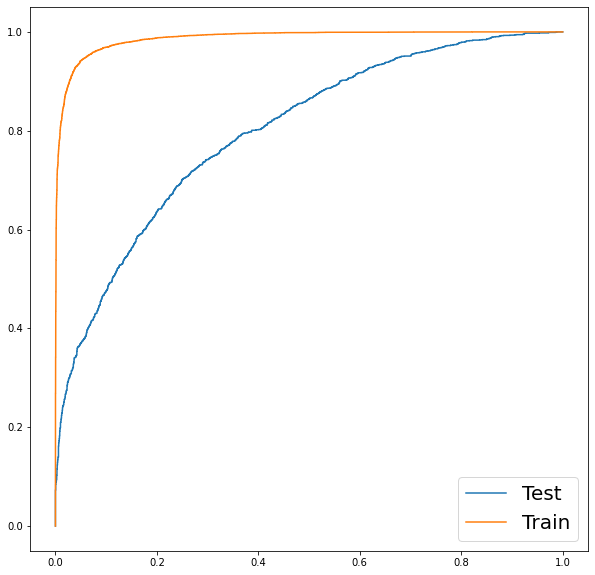

In [28]:
create_roc_curve(log_reg, y_test, y_train)

These are really good results for a first try, but we don't know if they are the best. In order to discover that, I'm going to attemp a grid search for the logistic regression.

### Logistic regression's grid search

In the param grid, we are adding both types of penalty, some different values for C, all solvers and a max_iter.

In [29]:
param_grid = [{'penalty' : ['l1', 'l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['liblinear'],
    'max_iter' : [1000]},
    {'penalty' : ['l2'],
    'C' : [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'solver' : ['newton-cg', 'lbfgs'],
    'max_iter' : [1000]}]


In [30]:
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid, verbose=True, n_jobs=-1)

In [31]:
%%time

best_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
CPU times: user 1.94 s, sys: 88.5 ms, total: 2.02 s
Wall time: 32.3 s


In [32]:
print('Best Score: %s' % best_clf.best_score_)
print('Best Hyperparameters: %s' % best_clf.best_params_)

Best Score: 0.742
Best Hyperparameters: {'C': 10, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}


In [33]:
best_model = best_clf.best_estimator_
y_hat = best_model.predict(tfidf_test)

#### Logistic regression's grid search metrics

In [34]:
get_metrics(y_test, y_hat)

accuracy = 0.73975, precision = 0.7397488466154885, recall = 0.73975, f1 = 0.7397390193133817


#### Logistic regression's grid search confusion matrix

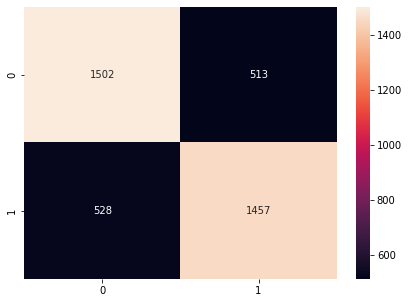

In [35]:
create_confusion_matrix(y_test, y_hat)

#### Logistic regression's grid search ROC curve

ROC AUC SCORE: 0.8218914813958286


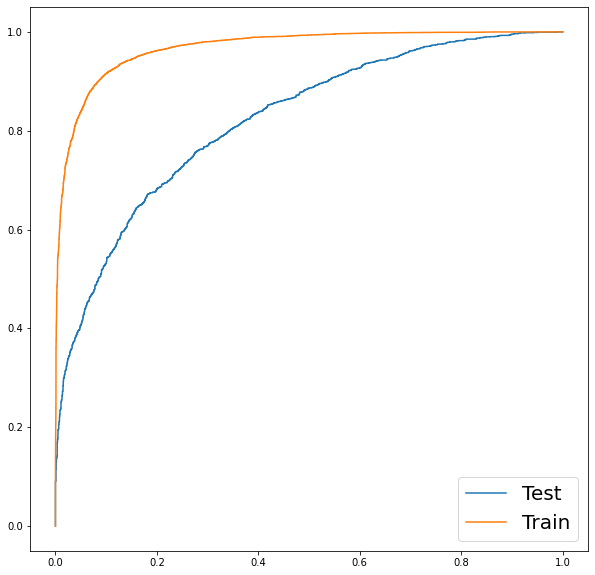

In [36]:
create_roc_curve(best_model, y_test, y_train)

What can we conclude from the logistic regression?

 - First of all, we get a slightly better result doing the grid search and obtaining the best hyperparameters for the model. 

 - Secondly, in the confusion matrix we can see that the number of false positives and false negatives doesn't vary a lot, which is good.

 - However, in the Roc curve we might say that there is some overfitting with the training set.

### Random forest

With the random forest, let's do a grid search directly. We are gonna use hyperparameters:
 - max_depth to control the maximum depth of the tree
 - max_features auto and sqrt to control the number of features when looking for the best split
 - n_estimators to pin the number of trees in the forest.

In [37]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
param_grid = {'max_depth': [None, 1,3,5,10],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100]}

In [39]:
grid = GridSearchCV(estimator = RandomForestClassifier(oob_score=True), param_grid = param_grid, verbose=True, n_jobs=-1)

In [40]:
%%time
best_rf_clf = grid.fit(tfidf_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 21.4 s, sys: 258 ms, total: 21.6 s
Wall time: 2min 33s


In [41]:
print('Best Score: %s' % best_rf_clf.best_score_)
print('Best Hyperparameters: %s' % best_rf_clf.best_params_)

Best Score: 0.6888125
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}


In [42]:
best_rf = best_rf_clf.best_estimator_
y_hat = best_rf.predict(tfidf_test)

#### Random forest's grid search metrics

In [43]:
get_metrics(y_test, y_hat)

accuracy = 0.685, precision = 0.6852410923457547, recall = 0.685, f1 = 0.6848034321864688


#### Random forest's grid confusion matrix

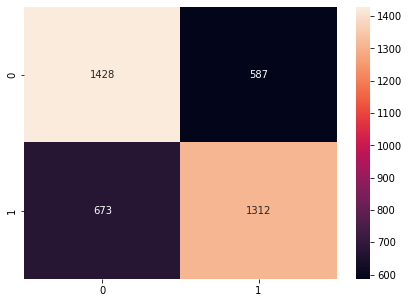

In [44]:
create_confusion_matrix(y_test, y_hat)

#### Random forest's grid search ROC curve

ROC AUC SCORE: 0.7546933264996156


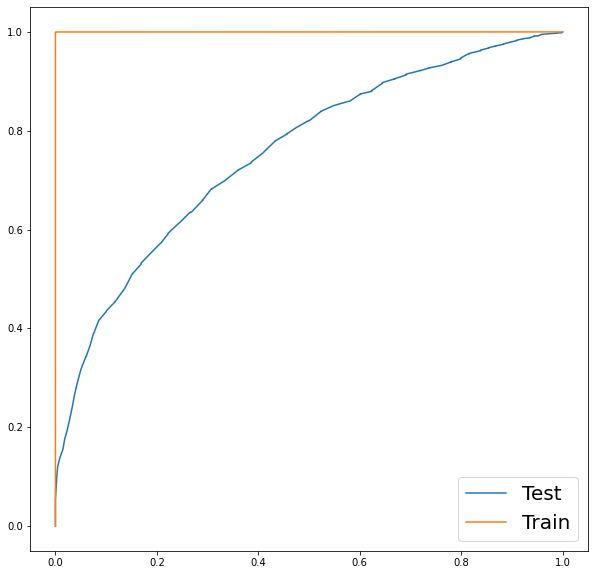

In [45]:
create_roc_curve(best_rf, y_test, y_train)

Although we get a slightly worst accuracy than in the logistic regression, random forest are a lot slower and show even more overfitting in the training set than the logistic regression. The logistic regression is the best model so far. But we can try some more.

### XGBoost

As I'm not that familiar with XGBoost models, let's do the same as in the logistic regression: do a first model with 'random' hyperparameters and then a grid search

In [46]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False
        )

In [47]:
%%time

xgb_model.fit(tfidf_train, y_train)

CPU times: user 11.1 s, sys: 55.9 ms, total: 11.1 s
Wall time: 11.2 s


XGBClassifier(max_depth=7, n_estimators=80, use_label_encoder=False)

In [48]:
y_hat = xgb_model.predict(tfidf_test)

#### XGBoost's metrics

In [49]:
get_metrics(y_test, y_hat)

accuracy = 0.6785, precision = 0.6789812228376941, recall = 0.6785, f1 = 0.6781486016857077


#### XGBoost's confusion matrix

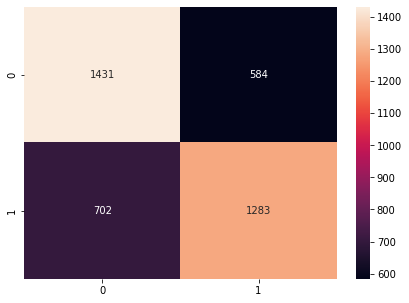

In [50]:
create_confusion_matrix(y_test, y_hat)

#### XGBoost's ROC curve

ROC AUC SCORE: 0.7549052134182548


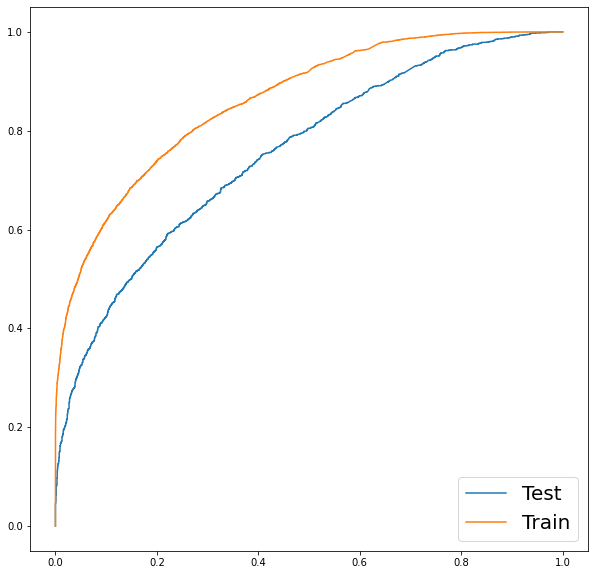

In [51]:
create_roc_curve(xgb_model, y_test, y_train)

### XGBoost's grid search

Hyperparameters used in the grid are:
 - max_depth to control the depth of the trees
 - n_estimators to control the number of trees
 - learning_rate to control how fast the model learns
 - booster is pinned to gbtree


In [52]:
param_grid = {
    'max_depth': [1, 3, 5, 10],
    'n_estimators': [10, 20, 40, 80],
    'learning_rate': [0.01, 0.05, 0.1],
    'booster' : ['gbtree']
    }

In [53]:
grid_search_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,seed=42),
    param_grid=param_grid,
    n_jobs = -1,
    verbose=True
)

In [54]:
%%time

best_xgb_clf = grid_search_xgb.fit(tfidf_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
CPU times: user 32 s, sys: 734 ms, total: 32.7 s
Wall time: 11min 30s


In [55]:
print('Best Score: %s' % best_xgb_clf.best_score_)
print('Best Hyperparameters: %s' % best_xgb_clf.best_params_)

Best Score: 0.6885
Best Hyperparameters: {'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 80}


In [56]:
best_xgb = best_xgb_clf.best_estimator_
y_hat = best_xgb.predict(tfidf_test)

#### XGBoost's grid search metrics

In [57]:
get_metrics(y_test, y_hat)

accuracy = 0.68925, precision = 0.6901066956551938, recall = 0.68925, f1 = 0.6887436708101756


#### XGBoost's grid search confusion matrix

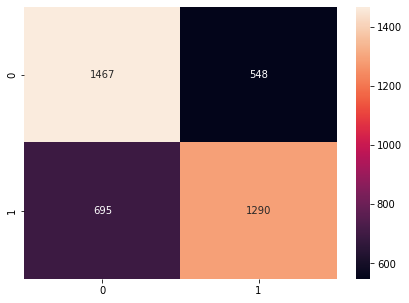

In [58]:
create_confusion_matrix(y_test, y_hat)

#### XGBoost's grid ROC curve

ROC AUC SCORE: 0.7629949184641636


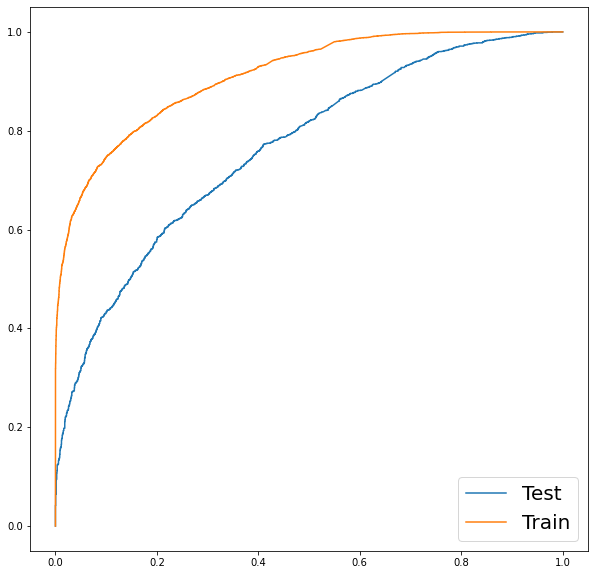

In [59]:
create_roc_curve(best_xgb, y_test, y_train)

This model gets an accuracy slighltly lower than logistic regression's, and it's also slower. However, it is the model which shows less overfitting in the training set so far. My conclussion is that we stick with the logistic regression.

### BERT 

BERT (Bidirectional Encoder Representations from Transformers) is a model for NLP developed in 2018 by researchers at Google AI Language and is really useful to solve binary classification problems. It has already been trained with a dataset of 3.3 Billion words, so we avoid that part, google has done it for us. 

First of all, let's install all the dependencies:

In [60]:
!pip install -q -U tensorflow-text

     |████████████████████████████████| 4.6 MB 1.3 MB/s 
     |████████████████████████████████| 511.7 MB 6.1 kB/s 
     |████████████████████████████████| 1.6 MB 46.9 MB/s 
     |████████████████████████████████| 438 kB 48.0 MB/s 
     |████████████████████████████████| 5.8 MB 27.6 MB/s 


In [61]:
!pip install -q tf-models-official

     |████████████████████████████████| 2.1 MB 5.1 MB/s 
     |████████████████████████████████| 43 kB 2.1 MB/s 
     |████████████████████████████████| 636 kB 18.3 MB/s 
     |████████████████████████████████| 352 kB 73.0 MB/s 
     |████████████████████████████████| 92 kB 12.0 MB/s 
     |████████████████████████████████| 237 kB 49.9 MB/s 
     |████████████████████████████████| 1.1 MB 47.9 MB/s 
     |████████████████████████████████| 48.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 55.0 MB/s 
     |████████████████████████████████| 99 kB 4.0 MB/s 


Now we shuffle the dataframe and split it in train and validation sets:

In [62]:
df_shuffled = shuffle(df)

In [63]:
len(df_shuffled)

20000

In [64]:
df_train = df_shuffled[:15999].reset_index()[['text','label_number']]
df_val = df_shuffled[16000:].reset_index()[['text','label_number']]

Let's import all the dependencies. In this case I'm trying out Tokenizer method from tensorflow.

In [65]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.preprocessing.text import Tokenizer

Now, we must create datasets to fit the model:

 - Create a tokenizer: 
  - fit_on_texts method creates the vocabulary index based on word frequency.
  - texts_to_sequences Transforms each text in texts to a sequence of integers.
 - tf.keras.preprocessing.sequence.pad_sequences is used to ensure that all sequences in a list have the same length.

That's enough to create the sequences, and combined with the labels using tf.data.Dataset.from_tensor_slices, we have the datasets to train and validate the model.


In [66]:
train_text = df_train['text'].to_numpy()

tok = Tokenizer(oov_token='<unk>')
tok.fit_on_texts(train_text)
tok.word_index['<pad>'] = 0
tok.index_word[0] = '<pad>'

train_seqs = tok.texts_to_sequences(train_text)
train_seqs = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

train_labels = df_train['label_number'].to_numpy().flatten()

val_text = df_val['text'].to_numpy()
val_seqs = tok.texts_to_sequences(val_text)
val_seqs = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')

val_labels = df_val['label_number'].to_numpy().flatten()

In [67]:
train_ds = tf.data.Dataset.from_tensor_slices((train_seqs, train_labels))
val_ds = tf.data.Dataset.from_tensor_slices((val_seqs, val_labels))

The next piece of code allows us to combines consecutive elements of this dataset into batches

In [68]:
BATCH_SIZE = 32
train_ds_batch = train_ds.batch(BATCH_SIZE)
val_ds_batch = val_ds.batch(BATCH_SIZE)

tf.data.Dataset.prefetch is used to decouple the time when data is produced from the time when data is consumed. The buffer_size tf.data.AUTOTUNE prompts the tf.data runtime to tune the value dynamically at runtime.

In [69]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_batch = train_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds_batch.cache().prefetch(buffer_size=AUTOTUNE)

Finally, let's create the model definition:

 - Model definition
  - First layer: create an embedding with first argument the number of distinct words in the training set, and second argument the size of the embedding vectors.
  - Second layer: defines global average pooling operation for temporal data.
  - Third layer: Dense layer with activation function sigmoid.

 - Model compiler 
  - optimizer adam is used very often for NLP problems, so that's my choice.
  - loss binary_crossentropy is used for bineary problems as it computes the cross-entropy loss between true labels and predicted labels.
  - accuracy is a good metric to compare the models.

In [70]:
from tensorflow import keras
from tensorflow.keras import layers

vocab_size =len(tok.word_index) + 1
embedding_dim = 256

model = keras.Sequential([
    layers.Embedding(vocab_size, embedding_dim),
    layers.GlobalAveragePooling1D(),
    layers.Dense(1, activation='sigmoid') # also tried activation='softmax'
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy'])

history = model.fit(
    train_ds_batch,
    epochs=3,
    validation_data=val_ds_batch, validation_steps=1, steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
)

Epoch 1/3
15999/15999 [==============================] - 66s 4ms/step - loss: 0.6374 - accuracy: 0.6404 - val_loss: 0.6014 - val_accuracy: 0.6875


So at first glance, BERT model is the one with worst results. 


## Feature importance

Now, let's see the feature importance of the logistic regression. In other words, let's see which words are more useful for the model to make the classification:

In [71]:
important_tokens = pd.DataFrame(
    data=best_model.coef_[0],
    index=vectorizer.get_feature_names(),
    columns=['Score']
).sort_values(by='Score' ,ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


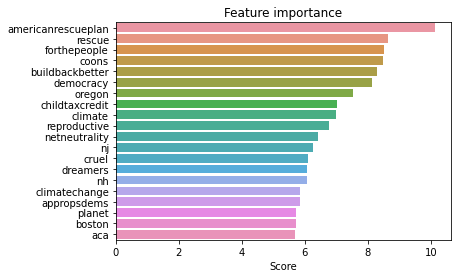

In [72]:
sns.barplot(x=important_tokens[:20]['Score'], y=important_tokens[:20].index).set_title('Feature importance');

## Using subsets of the dataframe: Why more isn't better

There are many ways to work with huge quantities of data: use a huge ad expensive machine, build a batch ETL to process everything at night or have patience of a saint, for example. I don't own a huge machine (neither want to invest all my savings on one in the cloud), didn't have time to build an ETL like that and didn't, don't and will never have a lot of patience. So I decided to invest some time in studying if more data in the model leads to better results.

For that purpose, I created a function with pieces of code from above to perform logistic regressions on different sets of data. It returns accuracy of the model and the trained model itself.

**DISCLIMER**: This process is really time consuming.

In [73]:
def steps_for_lg(df_original, vectorizer, sample_size):

  print(f'Executing sample_size = {sample_size}')

  df_d = shuffle(df_original[df_original['label']=='D'])[:sample_size]
  df_r = shuffle(df_original[df_original['label']=='R'])[:sample_size]
  df = df_d.append(df_r, ignore_index=True)

  df['text_corpus'] = df['text'].apply(create_corpus_column)

  df['label_number'] = df['label'].apply(lambda x: 0 if x == 'R' else 1)

  datos_X = df.text
  datos_y = df.label_number

  X_train, X_test, y_train, y_test = train_test_split(
      datos_X,
      datos_y,
      test_size = 0.2,
      random_state = 123
  )

  vectorizer.fit(X_train)

  tfidf_train = vectorizer.transform(X_train)
  tfidf_test  = vectorizer.transform(X_test)

  log_reg = LogisticRegression(C=10.0, solver='newton-cg', max_iter=1000)
  log_reg.fit(tfidf_train, y_train)

  y_hat = log_reg.predict(tfidf_test)

  accuracy = accuracy_score(y_test, y_hat)

  return accuracy, log_reg

In [74]:
sample_size_list = [100, 1000, 2500, 5000, 7500, 10000, 20000, 50000, 75000, 100000, 125000, 150000, 175000, 200000]
df_compute_results = pd.DataFrame(columns=['sample_size', 'accuracy', 'time'])

In [75]:
import time

for sample_size in sample_size_list:
  start_time = time.time()
  accuracy, log_reg_model = steps_for_lg(df_original, vectorizer, sample_size)
  finish_time = time.time() - start_time

  df_compute_results = df_compute_results.append({'sample_size': sample_size, 'accuracy': accuracy, 'time': finish_time}, ignore_index = True)

Executing sample_size = 100


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 1000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 2500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 5000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 7500


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 10000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 20000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 50000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 75000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 100000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 125000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 150000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 175000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


Executing sample_size = 200000


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"


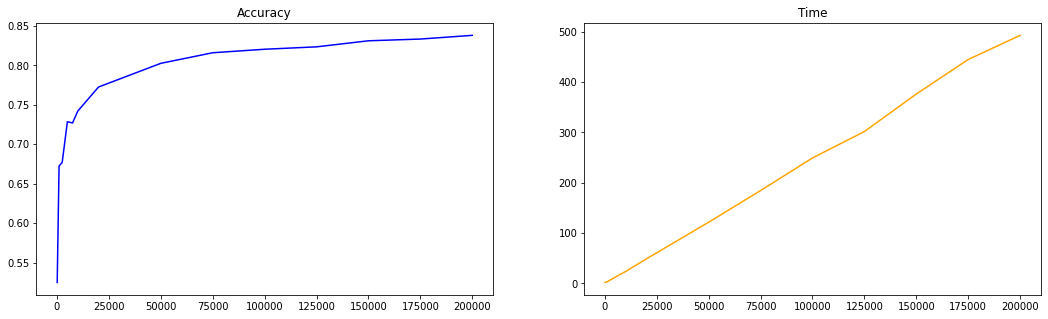

In [76]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(18,5))
ax1.plot(df_compute_results['sample_size'], df_compute_results['accuracy'], color='blue', label='accuracy')
ax1.set_title('Accuracy')
ax2.plot(df_compute_results['sample_size'], df_compute_results['time'], color='orange', label='time')
ax2.set_title('Time')
plt.show()

We can see that there is point where the accuracy starts to increase very slowly, so you can decide wether the investment of time or money is worth or not. 

Althought there is not a big difference in accuracy after 75000, the code was design to store the model trained with 200000 in the variable log_reg_model. If we invested the time, why not choose it?

## Download best model

In order to use the trained model again without executing it again, let's download it in pickle format:

In [89]:
import pickle

pickle.dump(log_reg_model, open('logistic_regression_model.pkl', 'wb'))

# Try it yourself!

In [94]:
your_tweet = 'Donald trump has been the best president of the EEUU so far'

In [95]:
your_tweet_series = pd.Series(your_tweet)
tfidf_custom_test  = vectorizer.transform(your_tweet_series)
pred = log_reg_model.predict(tfidf_custom_test)

In [97]:
log_reg_model.predict_proba(tfidf_custom_test)

array([[0.07249603, 0.92750397]])